# 1. Configuration

In [85]:
import os
import sys
import json
from datetime import datetime
from typing import Dict, List, Optional, Union, Tuple

# Data processing imports
import numpy as np
import pandas as pd

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning imports
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Optional imports - handle gracefully if not available
try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False

# Add parent directory to path for importing utilities
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir) if current_dir.endswith('notebooks') else current_dir
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import utility functions from the project
try:
    from src.utils.data_loader import (
        load_main_dataset, 
        load_trade_data, 
        load_data,
        get_token_ids_for_market,
        find_token_id_file
    )
except ImportError:
    print("Warning: Could not import data_loader utilities. Some functions may not work.")

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')



In [86]:
# 1. Configuration
MARKET_SELECTION = {
    'by_name': [
        "Will Donald Trump win the 2024 US Presidential Election?",
        "Will Kamala Harris win the 2024 US Presidential Election?"
    ],
    'by_id': [],  # Add specific market IDs here if needed
    'top_n_by_volume': 0,  # Set to a number > 0 to analyze top N markets by volume
    'min_volume': 0,  # Minimum volume threshold
    'date_range': None,  # Set to (start_date, end_date) to filter by date
}

# Analysis Configuration
ANALYSIS_CONFIG = {
    'run_trader_distribution': True,
    'run_whale_identification': True,
    'run_trader_classification': True,
    'run_market_dynamics': True,
    'whale_threshold': 0.01,  # Top 1% traders by volume are considered whales
    'trader_clusters': 5,  # Number of trader clusters for classification
    'save_results': True,  # Whether to save results to files
    'results_dir': 'results/trader_analysis',
    'generate_plots': True  # Whether to generate plots
}

# Create the results directory
os.makedirs(ANALYSIS_CONFIG['results_dir'], exist_ok=True)

# Initialize results dictionary
all_results = {}

# 2. Data Loading

In [87]:
def load_trade_data_for_analysis(market_ids):
    """
    Load and combine trade data for multiple markets
    
    Parameters:
    ----------
    market_ids : list
        List of market IDs to load
        
    Returns:
    --------
    pd.DataFrame
        Combined trade data for all markets
    """
    all_trades = []
    
    for market_id in market_ids:
        print(f"Loading trade data for market {market_id}...")
        
        try:
            # Use the imported load_trade_data function
            market_trades = load_trade_data(market_id)
            
            if market_trades is not None and len(market_trades) > 0:
                # Add market_id if not already present
                if 'market_id' not in market_trades.columns:
                    market_trades['market_id'] = market_id
                
                all_trades.append(market_trades)
        except Exception as e:
            print(f"Error loading trade data for market {market_id}: {e}")
    
    if not all_trades:
        print("No trade data found for selected markets")
        return None
    
    combined_trades = pd.concat(all_trades, ignore_index=True)
    print(f"Loaded {len(combined_trades):,} trades from {len(market_ids)} markets")
    
    return combined_trades

In [88]:
def load_market_data(market_config):
    """
    Load market data based on configuration
    
    Parameters:
    -----------
    market_config : dict
        Dictionary with market selection parameters
        
    Returns:
    --------
    tuple
        (market_data, trade_data) - DataFrames with market and trade data
    """
    print("Loading main dataset...")
    market_data = load_main_dataset('data/cleaned_election_data.csv')
    
    if market_data is None:
        print("Failed to load market data")
        return None, None
    
    # Filter markets based on configuration
    selected_markets = market_data.copy()
    
    # Filter by name if specified
    if market_config['by_name'] and len(market_config['by_name']) > 0:
        selected_markets = selected_markets[selected_markets['question'].isin(market_config['by_name'])]
        print(f"Selected {len(selected_markets)} markets by name")
    
    # Filter by ID if specified
    if market_config['by_id'] and len(market_config['by_id']) > 0:
        id_filter = selected_markets['id'].isin(market_config['by_id'])
        if len(selected_markets) > 0:
            selected_markets = selected_markets[id_filter]
        else:
            selected_markets = market_data[id_filter]
        print(f"Selected {len(selected_markets)} markets by ID")
    
    # Filter by top N by volume
    if market_config['top_n_by_volume'] > 0:
        if 'volumeNum' in market_data.columns:
            top_markets = market_data.sort_values('volumeNum', ascending=False).head(
                market_config['top_n_by_volume'])
            
            if len(selected_markets) > 0:
                # Intersect with already selected markets
                selected_markets = selected_markets[selected_markets['id'].isin(top_markets['id'])]
            else:
                selected_markets = top_markets
                
            print(f"Selected {len(selected_markets)} top markets by volume")
    
    # Apply minimum volume filter if specified
    if market_config['min_volume'] > 0 and 'volumeNum' in market_data.columns:
        volume_filter = selected_markets['volumeNum'] >= market_config['min_volume']
        selected_markets = selected_markets[volume_filter]
        print(f"Selected {len(selected_markets)} markets with minimum volume {market_config['min_volume']}")
    
    # If no markets were selected, use default selection
    if len(selected_markets) == 0:
        print("No markets matched selection criteria. Using default selection.")
        if market_config['top_n_by_volume'] > 0:
            selected_markets = market_data.sort_values('volumeNum', ascending=False).head(
                market_config['top_n_by_volume'])
        else:
            selected_markets = market_data.head(2)  # Default to first 2 markets
    
    print(f"Final selection: {len(selected_markets)} markets")
    
    # Display selected markets
    if len(selected_markets) > 0:
        print("\nSelected Markets:")
        for i, (idx, row) in enumerate(selected_markets.iterrows()):
            market_name = row['question'] if 'question' in row else f"Market {row['id']}"
            print(f"{i+1}. {market_name} (ID: {row['id']})")
    
    # Load trade data for selected markets
    market_ids = selected_markets['id'].tolist()
    trade_data = load_trade_data_for_analysis(market_ids=market_ids)
    
    return selected_markets, trade_data

# 3. Data Processing

In [89]:
def preprocess_trade_data(trade_data):
    """
    Preprocess trade data for analysis
    
    Parameters:
    -----------
    trade_data : pd.DataFrame
        Raw trade data
        
    Returns:
    --------
    pd.DataFrame
        Cleaned and preprocessed trade data
    """
    print("\n" + "="*80)
    print("DATA PREPROCESSING")
    print("="*80)
    
    if trade_data is None or len(trade_data) == 0:
        print("No trade data to preprocess")
        return None
    
    # Create a copy to avoid modifying the original
    df = trade_data.copy()
    
    # 1. Handle missing values
    initial_rows = len(df)
    print(f"Initial rows: {initial_rows:,}")
    
    # Check for missing values in key columns
    missing_values = df.isnull().sum()
    missing_cols = missing_values[missing_values > 0]
    if len(missing_cols) > 0:
        print("\nMissing values in key columns:")
        for col, missing in missing_cols.items():
            print(f"  {col}: {missing:,} ({missing/len(df)*100:.1f}%)")
    
    # Drop rows with missing critical values
    critical_columns = ['trader_id']
    if any(col in df.columns for col in critical_columns):
        present_critical = [col for col in critical_columns if col in df.columns]
        df = df.dropna(subset=present_critical)
        print(f"Rows after dropping missing critical values: {len(df):,}")
    
    # 2. Handle timestamps
    if 'timestamp' in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
            print("Converting timestamps to datetime...")
            try:
                df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
                df = df.dropna(subset=['timestamp'])
                print(f"Converted {len(df):,} timestamps")
            except Exception as e:
                print(f"Error converting timestamps: {e}")
                # Create a sequential index if conversion fails
                print("Creating sequential timestamps instead")
                df = df.sort_index()
                df['timestamp'] = pd.Series(range(len(df)))
        
        # Sort by timestamp
        df = df.sort_values('timestamp')
    
    # 3. Normalize trader IDs
    # Ensure consistent trader ID format
    if 'maker_id' in df.columns and 'trader_id' not in df.columns:
        df['trader_id'] = df['maker_id']
        print("Created trader_id from maker_id")
    elif 'maker' in df.columns and 'trader_id' not in df.columns:
        df['trader_id'] = df['maker']
        print("Created trader_id from maker column")
    
    # Check if there's a trader_id column now
    if 'trader_id' not in df.columns:
        print("Warning: No trader_id column available")
    else:
        # Convert trader_id to string type for consistency
        df['trader_id'] = df['trader_id'].astype(str)
        unique_traders = df['trader_id'].nunique()
        print(f"Unique traders identified: {unique_traders:,}")
    
    # 4. Normalize trade amounts
    # Check if we need to scale trade amounts
    if 'trade_amount' in df.columns:
        # Check if values are extremely large (likely in base units)
        median_value = df['trade_amount'].median()
        
        if median_value > 10000:  # Threshold suggesting base units
            scaling_factor = 1e6  # Standard scaling for USDC/USD
            print(f"Scaling trade_amount by factor of {scaling_factor:,.0f}")
            
            # Store original values
            df['trade_amount_original'] = df['trade_amount']
            
            # Scale values
            df['trade_amount'] = df['trade_amount'] / scaling_factor
    elif 'size' in df.columns and 'trade_amount' not in df.columns:
        # Convert size to numeric if needed
        df['size'] = pd.to_numeric(df['size'], errors='coerce')
        
        # Check if values are extremely large
        median_value = df['size'].median()
        
        if median_value > 10000:  # Threshold suggesting base units
            scaling_factor = 1e6  # Standard scaling for USDC/USD
            print(f"Creating trade_amount from size with scaling factor of {scaling_factor:,.0f}")
            
            # Create scaled trade_amount
            df['trade_amount'] = df['size'] / scaling_factor
        else:
            # Use size directly
            print("Creating trade_amount from size (no scaling needed)")
            df['trade_amount'] = df['size']
    else:
        print("Warning: No trade_amount or size column available")
        # Create a default trade_amount column if needed
        df['trade_amount'] = 1.0
        print("Created default trade_amount column with value 1.0")
    
    # 5. Add price change column if price exists
    if 'price' in df.columns:
        # Convert price to numeric
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        
        # Calculate price changes
        df['price_change'] = df['price'].diff()
        
        # Calculate summary statistics
        print("\nPrice statistics:")
        print(f"  Min: {df['price'].min():.6f}")
        print(f"  Max: {df['price'].max():.6f}")
        print(f"  Mean: {df['price'].mean():.6f}")
        print(f"  Std Dev: {df['price'].std():.6f}")
    
    # Print summary of preprocessing
    print("\nPreprocessing complete:")
    print(f"Initial rows: {initial_rows:,}")
    print(f"Final rows: {len(df):,}")
    print(f"Dropped rows: {initial_rows - len(df):,} ({(initial_rows - len(df))/initial_rows*100:.1f}%)")
    
    return df

In [90]:
def calculate_gini(values):
    """
    Calculate Gini coefficient for an array of values
    
    Parameters:
    -----------
    values : array-like
        Array of values (e.g., trader volumes)
        
    Returns:
    --------
    float
        Gini coefficient (0 = perfect equality, 1 = perfect inequality)
    """
    # Handle edge cases
    if len(values) <= 1 or np.sum(values) == 0:
        return 0
    
    # Sort values
    sorted_values = np.sort(values)
    n = len(sorted_values)
    
    # Calculate cumulative sum
    cumsum = np.cumsum(sorted_values)
    
    # Calculate Gini coefficient using the formula
    return (n + 1 - 2 * np.sum((n + 1 - np.arange(1, n+1)) * sorted_values) / np.sum(sorted_values)) / n

# 4. Analysis Functions

## a. Trader Distribution

In [91]:
def analyze_trader_distribution(trade_data, config, save_prefix='trader_distribution'):
    """
    Analyze trader distribution patterns
    
    Parameters:
    -----------
    trade_data : pd.DataFrame
        DataFrame with trade data
    config : dict
        Analysis configuration
    save_prefix : str
        Prefix for saved files
        
    Returns:
    --------
    dict
        Dictionary with analysis results
    """
    print("\n" + "="*80)
    print("TRADER DISTRIBUTION ANALYSIS")
    print("="*80)
    
    if trade_data is None or len(trade_data) == 0:
        print("No trade data available for analysis")
        return None
    
    results_dir = config['results_dir']
    os.makedirs(results_dir, exist_ok=True)
    
    # Calculate trader-level metrics
    trader_metrics = trade_data.groupby('trader_id').agg({
        'trade_amount': ['sum', 'mean', 'count'],
        'price': ['mean', 'std'] if 'price' in trade_data.columns else None
    })
    
    # Flatten column names
    trader_metrics.columns = [
        f"{col[0]}_{col[1]}" if col[1] else col[0] 
        for col in trader_metrics.columns
    ]
    
    # Reset index to make trader_id a column
    trader_metrics = trader_metrics.reset_index()
    
    # Calculate key statistics
    total_traders = len(trader_metrics)
    total_volume = trader_metrics['trade_amount_sum'].sum()
    avg_trades_per_trader = trader_metrics['trade_amount_count'].mean()
    median_trades_per_trader = trader_metrics['trade_amount_count'].median()
    
    print(f"Total traders: {total_traders:,}")
    print(f"Total volume: {total_volume:,.2f}")
    print(f"Average trades per trader: {avg_trades_per_trader:.2f}")
    print(f"Median trades per trader: {median_trades_per_trader:.0f}")
    
    # Create visualizations if enabled
    if config['generate_plots']:
        # 1. Trade count distribution
        plt.figure(figsize=(12, 8))
        
        # Use log scale for better visualization
        log_counts = np.log10(trader_metrics['trade_amount_count'] + 1)  # +1 to handle zeros
        
        plt.hist(log_counts, bins=50, alpha=0.7, color='skyblue')
        plt.title('Trader Activity Distribution (Log Scale)')
        plt.xlabel('Log10(Number of Trades)')
        plt.ylabel('Number of Traders')
        plt.grid(alpha=0.3)
        
        # Save and display plot
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f"{save_prefix}_activity.png"), dpi=300)
        plt.show()
        
        # 2. Volume distribution
        plt.figure(figsize=(12, 8))
        
        # Use log scale for better visualization
        log_volumes = np.log10(trader_metrics['trade_amount_sum'] + 1)  # +1 to handle zeros
        
        plt.hist(log_volumes, bins=50, alpha=0.7, color='green')
        plt.title('Trader Volume Distribution (Log Scale)')
        plt.xlabel('Log10(Trading Volume)')
        plt.ylabel('Number of Traders')
        plt.grid(alpha=0.3)
        
        # Save and display plot
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f"{save_prefix}_volume.png"), dpi=300)
        plt.show()
    
    # Create summary statistics for return
    deciles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]
    volume_percentiles = {
        f"{p}th_percentile": trader_metrics['trade_amount_sum'].quantile(p/100)
        for p in deciles
    }
    
    activity_percentiles = {
        f"{p}th_percentile": trader_metrics['trade_amount_count'].quantile(p/100)
        for p in deciles
    }
    
    summary = {
        'total_traders': total_traders,
        'total_volume': total_volume,
        'avg_trades_per_trader': avg_trades_per_trader,
        'median_trades_per_trader': median_trades_per_trader,
        'volume_percentiles': volume_percentiles,
        'activity_percentiles': activity_percentiles
    }
    
    # Save summary if enabled
    if config['save_results']:
        with open(os.path.join(results_dir, f"{save_prefix}_summary.json"), 'w') as f:
            json.dump(summary, f, indent=2, default=str)
    
    return summary, trader_metrics


## b. Whale Identification


In [92]:
# Fix for the identify_whales function's Lorenz curve plotting
def identify_whales(trade_data, config, save_prefix='whale_identification'):
    """
    Identify whale traders based on specified criteria
    
    Parameters:
    -----------
    trade_data : pd.DataFrame
        DataFrame with trade data
    config : dict
        Analysis configuration
    save_prefix : str
        Prefix for saved files
        
    Returns:
    --------
    tuple
        (whale_ids, whale_results) - List of whale IDs and analysis results
    """
    print("\n" + "="*80)
    print("WHALE TRADER IDENTIFICATION")
    print("="*80)
    
    if trade_data is None or len(trade_data) == 0:
        print("No trade data available for analysis")
        return [], {}
    
    # Ensure we have the necessary columns
    if 'trader_id' not in trade_data.columns or 'trade_amount' not in trade_data.columns:
        print("Error: Missing required columns (trader_id, trade_amount)")
        return [], {}
    
    # Get configuration parameters
    threshold = config['whale_threshold']
    results_dir = config['results_dir']
    generate_plots = config['generate_plots']
    
    os.makedirs(results_dir, exist_ok=True)
    
    # Group trades by trader and calculate total volume
    trader_volumes = trade_data.groupby('trader_id')['trade_amount'].sum().sort_values(ascending=False)
    
    # Calculate total volume
    total_volume = trader_volumes.sum()
    total_traders = len(trader_volumes)
    
    print(f"Total traders: {total_traders:,}")
    print(f"Total volume: {total_volume:,.2f}")
    
    # Create cumulative volume percentages
    cumulative_volumes = trader_volumes.cumsum()
    cumulative_percentages = cumulative_volumes / total_volume * 100
    
    # Create DataFrame for analysis
    trader_analysis = pd.DataFrame({
        'trader_id': trader_volumes.index,
        'volume': trader_volumes.values,
        'cumulative_volume': cumulative_volumes.values,
        'volume_pct': trader_volumes.values / total_volume * 100,
        'cumulative_pct': cumulative_percentages.values
    })
    
    # Calculate Gini coefficient
    gini = calculate_gini(trader_volumes.values)
    print(f"Volume concentration (Gini coefficient): {gini:.4f}")
    
    # Define percentile thresholds to evaluate
    percentile_thresholds = [0.001, 0.01, 0.05, 0.1]
    
    # Calculate metrics for each threshold
    threshold_metrics = []
    for pct in percentile_thresholds:
        num_whales = max(1, int(total_traders * pct))
        whale_volume = trader_volumes.iloc[:num_whales].sum()
        whale_volume_pct = whale_volume / total_volume * 100
        
        # Store metrics
        threshold_metrics.append({
            'threshold': pct,
            'threshold_label': f"Top {pct*100:.1f}%",
            'num_whales': num_whales,
            'whale_volume': float(whale_volume),
            'whale_volume_pct': float(whale_volume_pct),
            'trader_pct': float(num_whales / total_traders * 100)
        })
        
        print(f"Top {pct*100:.1f}% definition ({num_whales:,} traders): {whale_volume_pct:.2f}% of volume")
    
    # Calculate volume coverage thresholds
    volume_thresholds = [50, 75, 90, 95]
    coverage_metrics = []
    
    for pct in volume_thresholds:
        # Find traders needed to reach this volume percentage
        traders_needed = sum(cumulative_percentages < pct) + 1
        traders_needed = min(traders_needed, len(trader_volumes))
        
        # Get the actual volume percentage
        actual_pct = cumulative_percentages.iloc[traders_needed-1] if traders_needed <= len(cumulative_percentages) else 100
        
        coverage_metrics.append({
            'volume_threshold': pct,
            'threshold_label': f"{pct}% Volume",
            'num_traders': int(traders_needed),
            'actual_volume_pct': float(actual_pct),
            'trader_pct': float(traders_needed / total_traders * 100)
        })
        
        print(f"Traders needed for {pct}% volume: {traders_needed:,} ({traders_needed/total_traders*100:.4f}% of all traders)")
    
    # Create visualizations
    if generate_plots:
        # Create figure for combined plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # 1. Lorenz curve - FIX: Ensure x and y arrays have same dimension
        x_points = np.linspace(0, 100, len(trader_volumes) + 1)
        y_points = np.concatenate(([0], cumulative_percentages.values))
        
        ax1.plot(x_points, y_points, 'b-', linewidth=2, label='Volume distribution')
        ax1.plot([0, 100], [0, 100], 'k--', label='Perfect equality')
        ax1.fill_between(x_points, y_points, x_points, alpha=0.2)
        
        # Add key percentiles
        for p in [90, 95, 99, 99.9]:
            # Calculate index for this percentile
            idx = min(int(total_traders * (100-p)/100), len(trader_volumes)-1)
            if idx >= 0:
                # Get x and y coordinates
                x = idx / total_traders * 100
                y = cumulative_percentages.iloc[idx] if idx < len(cumulative_percentages) else 100
                
                # Add reference lines
                ax1.plot([x, x], [0, y], 'r--', alpha=0.5)
                ax1.plot([0, x], [y, y], 'r--', alpha=0.5)
                
                # Add label
                ax1.text(x + 1, 10 + (p-90)*3, f'Top {100-p}%', fontsize=10)
        
        ax1.set_title(f'Trading Volume Distribution (Gini: {gini:.4f})')
        ax1.set_xlabel('Cumulative % of Traders')
        ax1.set_ylabel('Cumulative % of Volume')
        ax1.grid(alpha=0.3)
        ax1.legend()
        
        # 2. Whale definition comparison
        percent_definitions = pd.DataFrame(threshold_metrics)
        
        # Plot bars for percentage of traders vs percentage of volume
        bar_width = 0.35
        x = np.arange(len(percent_definitions))
        
        ax2.bar(x - bar_width/2, percent_definitions['trader_pct'], 
               bar_width, label='% of Traders', color='skyblue')
        ax2.bar(x + bar_width/2, percent_definitions['whale_volume_pct'], 
               bar_width, label='% of Volume', color='orange')
        
        # Set x-axis labels
        ax2.set_xticks(x)
        ax2.set_xticklabels(percent_definitions['threshold_label'])
        
        # Add value labels on bars
        for i, v in enumerate(percent_definitions['trader_pct']):
            ax2.text(i - bar_width/2, v + 1, f"{v:.2f}%", ha='center', fontsize=9)
        
        for i, v in enumerate(percent_definitions['whale_volume_pct']):
            ax2.text(i + bar_width/2, v + 1, f"{v:.2f}%", ha='center', fontsize=9)
        
        ax2.set_title('Whale Definitions Comparison')
        ax2.set_ylabel('Percentage')
        ax2.set_ylim(0, 100)
        ax2.grid(axis='y', alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f"{save_prefix}_analysis.png"), dpi=300)
        plt.show()
        
        print(f"Whale definition analysis visualizations saved to {save_prefix}_analysis.png")
    
    # Use the specified threshold
    num_whales = max(1, int(total_traders * threshold))
    whale_ids = trader_volumes.head(num_whales).index.tolist()
    
    print(f"\nUsing top {threshold*100:.1f}% definition: {num_whales:,} whales")
    print(f"Selected whale threshold volume: {trader_volumes.iloc[num_whales-1] if num_whales <= len(trader_volumes) else 0:.2f}")
    
    # Save results if enabled
    results = {
        'gini_coefficient': gini,
        'threshold_used': threshold,
        'num_whales': num_whales,
        'threshold_metrics': threshold_metrics,
        'coverage_metrics': coverage_metrics,
        'whale_volume_percentage': float(trader_volumes.head(num_whales).sum() / total_volume * 100)
    }
    
    if config['save_results']:
        with open(os.path.join(results_dir, f"{save_prefix}_results.json"), 'w') as f:
            json.dump(results, f, indent=2, default=str)
    
    # Return whale IDs and analysis results
    return whale_ids, results

## d. Trader Classification

In [93]:
# Change this line in cell #9
def run_trader_classification_analysis(trade_data, min_clusters=2, max_clusters=5, random_state=42, save_dir='results/trader_analysis'):
    """
    Classify traders based on their behavior patterns using clustering
    
    Parameters:
    -----------
    trade_data : pd.DataFrame
        DataFrame with trader data
    min_clusters : int
        Minimum number of clusters to try
    max_clusters : int
        Maximum number of clusters to try
    random_state : int
        Random seed for reproducibility
    save_dir : str
        Directory to save results
        
    Returns:
    --------
    dict
        Dictionary with classification results
    """
    # Check required columns
    required_cols = ['trader_id', 'trade_amount']
    missing_cols = [col for col in required_cols if col not in trade_data.columns]
    
    if missing_cols:
        print(f"Error: Missing required columns: {missing_cols}")
        return None
    
    # Create trader features
    trader_features = []
    
    # Group trades by trader
    for trader_id, trader_df in trade_data.groupby('trader_id'):
        # Skip traders with too few trades
        if len(trader_df) < 3:
            continue
            
        # Calculate trader metrics
        metrics = {
            'trader_id': trader_id,
            'trade_count': len(trader_df),
            'total_volume': trader_df['trade_amount'].sum(),
            'avg_trade_size': trader_df['trade_amount'].mean(),
            'trade_frequency': len(trader_df) / (trader_df['timestamp'].max() - trader_df['timestamp'].min()).total_seconds() if 'timestamp' in trader_df.columns else np.nan
        }
        
        # Add price volatility if available
        if 'price' in trader_df.columns:
            metrics['price_volatility'] = trader_df['price'].std() / trader_df['price'].mean() if trader_df['price'].mean() > 0 else np.nan
        
        # Add direction bias if available
        if 'side' in trader_df.columns:
            buy_count = (trader_df['side'] == 'buy').sum()
            sell_count = (trader_df['side'] == 'sell').sum()
            total_side_count = buy_count + sell_count
            
            if total_side_count > 0:
                metrics['buy_ratio'] = buy_count / total_side_count
        
        trader_features.append(metrics)
    
    # Convert to DataFrame
    trader_df = pd.DataFrame(trader_features)
    
    if len(trader_df) < min_clusters:
        print(f"Error: Not enough traders ({len(trader_df)}) for clustering (min: {min_clusters})")
        return None
    
    # Select features for clustering
    cluster_features = [col for col in ['trade_count', 'avg_trade_size', 'price_volatility', 
                                      'trade_frequency', 'buy_ratio'] 
                      if col in trader_df.columns]
    
    if len(cluster_features) < 2:
        print(f"Error: Not enough features for clustering")
        return None
    
    # Create feature matrix and standardize
    X = trader_df[cluster_features].copy()
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Find optimal number of clusters
    inertia = []
    for n_clusters in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    
    # Find elbow point (if available)
    if len(inertia) > 2:
        # Find the point with maximum curvature (simplified approach)
        diffs = np.diff(inertia)
        optimal_clusters = min_clusters + np.argmax(np.abs(np.diff(diffs))) + 1
        optimal_clusters = max(min_clusters, min(optimal_clusters, max_clusters))
    else:
        # Default to middle point
        optimal_clusters = (min_clusters + max_clusters) // 2
    
    # Cluster with optimal number
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=random_state, n_init=10)
    trader_df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Calculate cluster profiles
    cluster_profiles = trader_df.groupby('cluster').agg({
        'trade_count': 'mean',
        'total_volume': 'sum',
        'avg_trade_size': 'mean',
        'trader_id': 'count'
    }).rename(columns={'trader_id': 'count'})
    
    # Add additional metrics if available
    for feature in ['price_volatility', 'trade_frequency', 'buy_ratio']:
        if feature in trader_df.columns:
            cluster_profiles[feature] = trader_df.groupby('cluster')[feature].mean()
    
    # Calculate feature importance
    feature_importance = {}
    for i, feature in enumerate(cluster_features):
        feature_importance[feature] = np.std([c[i] for c in kmeans.cluster_centers_])
    
    # Name clusters based on characteristics
    cluster_names = {}
    detailed_profiles = []
    
    for cluster_id, profile in cluster_profiles.iterrows():
        # Extract key metrics
        count = profile['count']
        percentage = 100 * count / len(trader_df)
        avg_trades = profile['trade_count']
        avg_size = profile['avg_trade_size']
        volume_percentage = 100 * profile['total_volume'] / trader_df['total_volume'].sum()
        
        # Determine type based on trade count and size
        if avg_trades > trader_df['trade_count'].quantile(0.8) and avg_size > trader_df['avg_trade_size'].quantile(0.8):
            trader_type = "Whale Traders"
            description = "High volume, large trades"
        elif avg_trades > trader_df['trade_count'].quantile(0.8) and avg_size < trader_df['avg_trade_size'].quantile(0.5):
            trader_type = "High-Frequency Traders"
            description = "Many small-to-medium trades"
        elif avg_trades < trader_df['trade_count'].quantile(0.2) and avg_size > trader_df['avg_trade_size'].quantile(0.8):
            trader_type = "Occasional Big Traders"
            description = "Few but large trades"
        elif 'buy_ratio' in profile and profile['buy_ratio'] > 0.7:
            trader_type = "Bull Traders"
            description = "Predominantly buy trades" 
        elif 'buy_ratio' in profile and profile['buy_ratio'] < 0.3:
            trader_type = "Bear Traders"
            description = "Predominantly sell trades"
        elif 'price_volatility' in profile and profile['price_volatility'] > trader_df['price_volatility'].quantile(0.8):
            trader_type = "Momentum Traders"
            description = "Active during price volatility"
        else:
            trader_type = f"Retail Traders Type {cluster_id}"
            description = "Average trading patterns"
        
        # Store cluster name
        cluster_names[cluster_id] = trader_type
        
        # Add detailed profile
        detailed_profiles.append({
            'cluster_id': int(cluster_id),
            'trader_type': trader_type,
            'description': description,
            'count': int(count),
            'percentage': float(percentage),
            'avg_trades': float(avg_trades),
            'avg_trade_size': float(avg_size),
            'volume_percentage': float(volume_percentage)
        })
    
    # Add cluster name to trader DataFrame
    trader_df['trader_type'] = trader_df['cluster'].map(cluster_names)
    
    # Create visualizations if save_dir is provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        
        # 1. Cluster scatter plot
        if len(cluster_features) >= 2:
            plt.figure(figsize=(10, 8))
            
            # Use PCA to reduce to 2D if needed
            if len(cluster_features) > 2:
                pca = PCA(n_components=2)
                X_2d = pca.fit_transform(X_scaled)
                x_label = 'PCA Component 1'
                y_label = 'PCA Component 2'
            else:
                X_2d = X_scaled
                x_label = cluster_features[0]
                y_label = cluster_features[1]
            
            # Plot clusters
            for cluster in range(optimal_clusters):
                cluster_points = X_2d[trader_df['cluster'] == cluster]
                plt.scatter(
                    cluster_points[:, 0], 
                    cluster_points[:, 1], 
                    label=cluster_names[cluster],
                    alpha=0.7
                )
            
            plt.title('Trader Type Clusters')
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.legend()
            plt.grid(alpha=0.3)
            plt.savefig(os.path.join(save_dir, 'trader_clusters.png'), dpi=300)
            plt.close()
            
        # 2. Cluster profile radar chart
        if len(cluster_features) >= 3:
            # Create normalized feature values for radar chart
            feature_values = {}
            for feature in cluster_features:
                feature_max = cluster_profiles[feature].max() if feature in cluster_profiles else 1
                feature_values[feature] = cluster_profiles[feature] / feature_max if feature in cluster_profiles else pd.Series([0] * len(cluster_profiles))
            
            # Create a figure with a radar chart for each cluster
            fig, axs = plt.subplots(1, len(cluster_profiles), figsize=(15, 5), subplot_kw=dict(polar=True))
            
            # Handle case with only one cluster
            if len(cluster_profiles) == 1:
                axs = [axs]
            
            # Create angles for features
            angles = np.linspace(0, 2*np.pi, len(cluster_features), endpoint=False).tolist()
            angles += angles[:1]  # Close the loop
            
            for i, (cluster_id, profile) in enumerate(cluster_profiles.iterrows()):
                ax = axs[i]
                
                # Get values for this cluster
                values = [feature_values[feature].loc[cluster_id] for feature in cluster_features]
                values += values[:1]  # Close the loop
                
                # Plot values
                ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster_id}')
                ax.fill(angles, values, alpha=0.25)
                
                # Set labels
                ax.set_xticks(angles[:-1])
                ax.set_xticklabels(cluster_features, size=8)
                ax.set_title(cluster_names[cluster_id], size=10)
            
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, 'trader_profiles.png'), dpi=300)
            plt.close()
            
        # 3. Cluster distribution pie chart
        plt.figure(figsize=(10, 6))
        counts = trader_df['trader_type'].value_counts()
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
        plt.axis('equal')
        plt.title('Distribution of Trader Types')
        plt.savefig(os.path.join(save_dir, 'trader_type_distribution.png'), dpi=300)
        plt.close()
    
    # Return results
    return {
        'trader_features': trader_df,
        'cluster_profiles': cluster_profiles,
        'cluster_names': cluster_names,
        'feature_importance': feature_importance,
        'optimal_clusters': optimal_clusters,
        'detailed_profiles': detailed_profiles
    }

## e. Market Dynamics

In [94]:

# 5.4 Market Dynamics Analysis
def analyze_market_dynamics(trade_data, whale_ids, market_data, config, save_prefix='market_dynamics'):
    """
    Analyze market dynamics including whale impact and price movements
    
    Parameters:
    -----------
    trade_data : pd.DataFrame
        DataFrame with trade data
    whale_ids : list
        List of whale trader IDs
    market_data : pd.DataFrame
        DataFrame with market metadata
    config : dict
        Analysis configuration
    save_prefix : str
        Prefix for saved files
        
    Returns:
    --------
    dict
        Dictionary with market dynamics analysis results
    """
    print("\n" + "="*80)
    print("MARKET DYNAMICS ANALYSIS")
    print("="*80)
    
    if trade_data is None or len(trade_data) == 0:
        print("No trade data available for analysis")
        return None
    
    if not whale_ids:
        print("No whale traders identified for analysis")
        return None
    
    results_dir = config['results_dir']
    generate_plots = config['generate_plots']
    
    os.makedirs(results_dir, exist_ok=True)
    
    # Clean the data
    df = trade_data.copy()
    
    # Add whale indicator
    df['is_whale'] = df['trader_id'].isin(whale_ids)
    
    # Ensure price is numeric
    if 'price' in df.columns:
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
    
    # Split whale and non-whale trades
    whale_trades = df[df['is_whale']]
    non_whale_trades = df[~df['is_whale']]
    
    print(f"Analyzing {len(whale_trades)} whale trades and {len(non_whale_trades)} non-whale trades")
    
    # Market-level price impact analysis
    if 'market_id' in df.columns and 'price' in df.columns:
        market_impacts = []
        
        for market_id, market_df in df.groupby('market_id'):
            # Skip markets with too few trades
            if len(market_df) < 10:
                continue
                
            # Sort by timestamp
            if 'timestamp' in market_df.columns:
                if not pd.api.types.is_datetime64_any_dtype(market_df['timestamp']):
                    try:
                        market_df['timestamp'] = pd.to_datetime(market_df['timestamp'], errors='coerce')
                        market_df = market_df.dropna(subset=['timestamp'])
                    except:
                        # Create a sequential timestamp if conversion fails
                        market_df = market_df.sort_index()
                        market_df['timestamp'] = pd.Series(range(len(market_df)))
                
                market_df = market_df.sort_values('timestamp')
            
            # Calculate price changes
            market_df['price_change'] = market_df['price'].diff()
            
            # Skip markets with no price changes
            if market_df['price_change'].isna().all() or market_df['price_change'].abs().sum() == 0:
                continue
            
            # Separate whale and non-whale trades
            market_whale_trades = market_df[market_df['is_whale']]
            market_non_whale_trades = market_df[~market_df['is_whale']]
            
            # Skip markets with no whale trades
            if len(market_whale_trades) == 0:
                continue
                
            # Calculate average metrics
            whale_avg_change = market_whale_trades['price_change'].mean()
            non_whale_avg_change = market_non_whale_trades['price_change'].mean()
            
            # Calculate directional impact
            whale_pos_pct = (market_whale_trades['price_change'] > 0).mean() * 100
            whale_neg_pct = (market_whale_trades['price_change'] < 0).mean() * 100
            non_whale_pos_pct = (market_non_whale_trades['price_change'] > 0).mean() * 100
            non_whale_neg_pct = (market_non_whale_trades['price_change'] < 0).mean() * 100
            
            # Get market name if available
            if 'question' in market_data.columns:
                market_name = market_data.loc[market_data['id'] == market_id, 'question'].iloc[0] if not market_data.loc[market_data['id'] == market_id, 'question'].empty else f"Market {market_id}"
            else:
                market_name = f"Market {market_id}"
            
            market_impacts.append({
                'market_id': market_id,
                'market_name': market_name,
                'total_trades': len(market_df),
                'whale_trades': len(market_whale_trades),
                'non_whale_trades': len(market_non_whale_trades),
                'whale_trade_pct': len(market_whale_trades) / len(market_df) * 100,
                'whale_avg_change': float(whale_avg_change),
                'non_whale_avg_change': float(non_whale_avg_change),
                'whale_pos_pct': float(whale_pos_pct),
                'whale_neg_pct': float(whale_neg_pct),
                'non_whale_pos_pct': float(non_whale_pos_pct),
                'non_whale_neg_pct': float(non_whale_neg_pct)
            })
        
        # Create markets DataFrame
        if market_impacts:
            markets_df = pd.DataFrame(market_impacts)
            
            # Calculate weighted averages
            weighted_whale_impact = np.average(
                markets_df['whale_avg_change'],
                weights=markets_df['whale_trades']
            )
            
            weighted_non_whale_impact = np.average(
                markets_df['non_whale_avg_change'],
                weights=markets_df['non_whale_trades']
            )
            
            print(f"\nWeighted average whale price impact: {weighted_whale_impact:.6f}")
            print(f"Weighted average non-whale price impact: {weighted_non_whale_impact:.6f}")
            
            # Calculate impact ratio if possible
            if weighted_non_whale_impact != 0:
                impact_ratio = weighted_whale_impact / weighted_non_whale_impact
                print(f"Impact ratio (whale/non-whale): {impact_ratio:.4f}")
            else:
                impact_ratio = None
                print("Impact ratio cannot be calculated (division by zero)")
            
            # Create visualizations
            if generate_plots:
                plt.figure(figsize=(15, 12))
                
                # 1. Market-by-market comparison
                plt.subplot(2, 1, 1)
                
                # Sort markets by whale impact
                sorted_markets = markets_df.sort_values('whale_avg_change')
                
                # Plot whale vs non-whale impact by market
                plt.scatter(range(len(sorted_markets)), sorted_markets['whale_avg_change'], 
                           label='Whale impact', alpha=0.7, s=50, color='blue')
                plt.scatter(range(len(sorted_markets)), sorted_markets['non_whale_avg_change'], 
                           label='Non-whale impact', alpha=0.7, s=50, color='orange')
                
                plt.axhline(y=0, color='r', linestyle='--')
                plt.title('Price Impact by Market')
                plt.xlabel('Markets (sorted by whale impact)')
                plt.ylabel('Average Price Change')
                plt.legend()
                plt.grid(alpha=0.3)
                
                # 2. Direction comparison
                plt.subplot(2, 1, 2)
                
                # Calculate average positive/negative percentages
                avg_whale_pos = markets_df['whale_pos_pct'].mean()
                avg_whale_neg = markets_df['whale_neg_pct'].mean()
                avg_nonwhale_pos = markets_df['non_whale_pos_pct'].mean()
                avg_nonwhale_neg = markets_df['non_whale_neg_pct'].mean()
                
                # Plot directional impact
                labels = ['Whale', 'Non-whale']
                pos_values = [avg_whale_pos, avg_nonwhale_pos]
                neg_values = [avg_whale_neg, avg_nonwhale_neg]
                neutral_values = [100 - avg_whale_pos - avg_whale_neg, 
                                 100 - avg_nonwhale_pos - avg_nonwhale_neg]
                
                width = 0.35
                x = np.arange(len(labels))
                
                plt.bar(x, pos_values, width, label='Positive impact', color='green')
                plt.bar(x, neg_values, width, bottom=pos_values, label='Negative impact', color='red')
                plt.bar(x, neutral_values, width, 
                       bottom=[pos_values[i] + neg_values[i] for i in range(len(pos_values))], 
                       label='Neutral', color='gray')
                
                plt.title('Direction of Price Impact')
                plt.ylabel('Percentage of Trades')
                plt.xlabel('Trader Type')
                plt.xticks(x, labels)
                plt.legend()
                
                plt.tight_layout()
                plt.savefig(os.path.join(results_dir, f"{save_prefix}_price_impact.png"), dpi=300)
                plt.show()
                
                print(f"Market price impact visualization saved to {save_prefix}_price_impact.png")
            
            # Save results if enabled
            results = {
                'market_impacts': [m for m in market_impacts if isinstance(m, dict)],
                'weighted_whale_impact': float(weighted_whale_impact),
                'weighted_non_whale_impact': float(weighted_non_whale_impact),
                'impact_ratio': float(impact_ratio) if impact_ratio is not None else None,
                'avg_whale_positive_pct': float(avg_whale_pos),
                'avg_whale_negative_pct': float(avg_whale_neg),
                'avg_nonwhale_positive_pct': float(avg_nonwhale_pos),
                'avg_nonwhale_negative_pct': float(avg_nonwhale_neg)
            }
            
            if config['save_results']:
                with open(os.path.join(results_dir, f"{save_prefix}_results.json"), 'w') as f:
                    json.dump(results, f, indent=2, default=str)
            
            return results
    
    # If market-level analysis was not possible, do overall analysis
    print("Analyzing overall price changes...")
    
    # Calculate metrics
    whale_avg_change = whale_trades['price_change'].mean() if 'price_change' in whale_trades.columns else None
    whale_median_change = whale_trades['price_change'].median() if 'price_change' in whale_trades.columns else None
    whale_std_change = whale_trades['price_change'].std() if 'price_change' in whale_trades.columns else None
    
    non_whale_avg_change = non_whale_trades['price_change'].mean() if 'price_change' in non_whale_trades.columns else None
    non_whale_median_change = non_whale_trades['price_change'].median() if 'price_change' in non_whale_trades.columns else None
    non_whale_std_change = non_whale_trades['price_change'].std() if 'price_change' in non_whale_trades.columns else None
    
    if all(x is not None for x in [whale_avg_change, non_whale_avg_change]):
        print(f"\nWhale trades average price change: {whale_avg_change:.6f}")
        print(f"Non-whale trades average price change: {non_whale_avg_change:.6f}")
    else:
        print("Price change metrics not available")
        
    results = {
        'overall_metrics': {
            'whale_avg_change': float(whale_avg_change) if whale_avg_change is not None else None,
            'whale_median_change': float(whale_median_change) if whale_median_change is not None else None,
            'whale_std_change': float(whale_std_change) if whale_std_change is not None else None,
            'non_whale_avg_change': float(non_whale_avg_change) if non_whale_avg_change is not None else None,
            'non_whale_median_change': float(non_whale_median_change) if non_whale_median_change is not None else None,
            'non_whale_std_change': float(non_whale_std_change) if non_whale_std_change is not None else None
        }
    }
    
    if config['save_results']:
        with open(os.path.join(results_dir, f"{save_prefix}_results.json"), 'w') as f:
            json.dump(results, f, indent=2, default=str)
    
    return results

## f. Temporal Analaysis

In [95]:
def analyze_trader_temporal_patterns(trade_data, trader_types_df):
    """
    Analyze how different trader types behave over time
    
    Parameters:
    -----------
    trade_data : pd.DataFrame
        DataFrame with trade data including timestamps
    trader_types_df : pd.DataFrame
        DataFrame with trader classification results
        
    Returns:
    --------
    dict
        Dictionary with temporal analysis results
    """
    # Ensure we have timestamp data
    if 'timestamp' not in trade_data.columns:
        print("Error: No timestamp data available for temporal analysis")
        return None
    
    # Ensure timestamp is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(trade_data['timestamp']):
        try:
            trade_data['timestamp'] = pd.to_datetime(trade_data['timestamp'])
        except:
            print("Error: Could not convert timestamps to datetime")
            return None
    
    # Merge trader types to trade data
    if 'trader_id' in trade_data.columns and 'trader_id' in trader_types_df.columns and 'trader_type' in trader_types_df.columns:
        trade_data = trade_data.merge(
            trader_types_df[['trader_id', 'trader_type']], 
            on='trader_id', 
            how='left'
        )
    else:
        print("Error: Cannot merge trader types - missing required columns")
        return None
    
    # Create time periods
    trade_data['date'] = trade_data['timestamp'].dt.date
    
    # Find overall market start and end date
    start_date = trade_data['date'].min()
    end_date = trade_data['date'].max()
    market_duration = (end_date - start_date).days
    
    # Define periods
    if market_duration >= 30:
        # For longer markets, use weeks
        trade_data['week'] = (trade_data['timestamp'] - pd.Timestamp(start_date)).dt.days // 7
        period_col = 'week'
        period_name = 'Week'
    else:
        # For shorter markets, use days
        trade_data['day'] = (trade_data['timestamp'] - pd.Timestamp(start_date)).dt.days
        period_col = 'day'
        period_name = 'Day'
    
    # Calculate period entry points for each trader type
    entry_periods = {}
    trader_entries = trade_data.groupby(['trader_id', 'trader_type'])[period_col].min().reset_index()
    for trader_type, group in trader_entries.groupby('trader_type'):
        entry_periods[trader_type] = {
            'mean': group[period_col].mean(),
            'median': group[period_col].median(),
            'p25': group[period_col].quantile(0.25),
            'p75': group[period_col].quantile(0.75),
        }
    
    # Calculate activity by period and trader type
    activity_by_period = trade_data.groupby([period_col, 'trader_type']).agg({
        'trade_amount': ['sum', 'mean', 'count'],
        'trader_id': 'nunique'
    }).reset_index()
    
    # Rename columns
    activity_by_period.columns = [
        period_col if c == period_col else 'trader_type' if c == 'trader_type' 
        else f"{c[0]}_{c[1]}" for c in activity_by_period.columns
    ]
    
    # Calculate percentage of active traders by period
    total_traders_by_type = trader_types_df.groupby('trader_type').size()
    for trader_type in total_traders_by_type.index:
        type_rows = activity_by_period['trader_type'] == trader_type
        activity_by_period.loc[type_rows, 'trader_participation_pct'] = (
            100 * activity_by_period.loc[type_rows, 'trader_id_nunique'] / total_traders_by_type[trader_type]
        )
    
    # Create visualizations
    plt.figure(figsize=(12, 8))
    
    # Plot volume by trader type over time
    volume_pivot = pd.pivot_table(
        activity_by_period, 
        values='trade_amount_sum', 
        index=period_col, 
        columns='trader_type'
    ).fillna(0)
    
    ax = volume_pivot.plot(figsize=(12, 6))
    plt.title(f'Trading Volume by Trader Type Over Time')
    plt.xlabel(f'{period_name} (since market start)')
    plt.ylabel('Trading Volume')
    plt.grid(alpha=0.3)
    plt.legend(title='Trader Type')
    plt.tight_layout()
    plt.savefig('results/temporal_volume_by_type.png', dpi=300)
    plt.close()
    
    # Plot trader participation
    participation_pivot = pd.pivot_table(
        activity_by_period, 
        values='trader_participation_pct', 
        index=period_col, 
        columns='trader_type'
    ).fillna(0)
    
    ax = participation_pivot.plot(figsize=(12, 6))
    plt.title(f'Trader Participation Rate by Type Over Time')
    plt.xlabel(f'{period_name} (since market start)')
    plt.ylabel('Participation Rate (%)')
    plt.grid(alpha=0.3)
    plt.legend(title='Trader Type')
    plt.tight_layout()
    plt.savefig('results/temporal_participation_by_type.png', dpi=300)
    plt.close()
    
    # Return complete analysis results
    return {
        'market_duration': market_duration,
        'period_type': period_name,
        'entry_periods': entry_periods,
        'activity_by_period': activity_by_period.to_dict('records'),
        'total_periods': activity_by_period[period_col].max() + 1
    }

## g. Network Effects

In [96]:
def analyze_network_effects(trade_data, trader_types_df, whale_ids, time_window_minutes=60):
    """
    Analyze network effects between trader types - how they influence each other
    
    Parameters:
    -----------
    trade_data : pd.DataFrame
        DataFrame with trade data
    trader_types_df : pd.DataFrame
        DataFrame with trader classification results
    whale_ids : list
        List of whale trader IDs
    time_window_minutes : int
        Time window for analyzing following behavior (in minutes)
        
    Returns:
    --------
    dict
        Dictionary with network analysis results
    """
    # Ensure we have timestamp data
    if 'timestamp' not in trade_data.columns:
        print("Error: No timestamp data available for network analysis")
        return None
    
    # Ensure timestamp is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(trade_data['timestamp']):
        try:
            trade_data['timestamp'] = pd.to_datetime(trade_data['timestamp'])
        except:
            print("Error: Could not convert timestamps to datetime")
            return None
    
    # Merge trader types to trade data
    if 'trader_id' in trade_data.columns and 'trader_id' in trader_types_df.columns and 'trader_type' in trader_types_df.columns:
        trade_data = trade_data.merge(
            trader_types_df[['trader_id', 'trader_type']], 
            on='trader_id', 
            how='left'
        )
    else:
        print("Error: Cannot merge trader types - missing required columns")
        return None
    
    # Add whale indicator based on ID list
    trade_data['is_whale'] = trade_data['trader_id'].isin(whale_ids)
    
    # Sort trades by timestamp
    trade_data = trade_data.sort_values('timestamp')
    
    # Create time windows for analyzing following behavior
    trade_data['timestamp_window'] = trade_data['timestamp'].dt.floor(f'{time_window_minutes}min')
    
    # Create side indicator if available (buy=1, sell=-1)
    if 'side' in trade_data.columns:
        trade_data['side_value'] = trade_data['side'].map({'buy': 1, 'sell': -1})
    
    # Analyze following behavior after whale trades
    following_behavior = []
    
    # Group by time windows
    for window, window_trades in trade_data.groupby('timestamp_window'):
        # Skip windows with too few trades
        if len(window_trades) < 3:
            continue
        
        # Check if there are whale trades in this window
        whale_trades = window_trades[window_trades['is_whale']]
        if len(whale_trades) == 0:
            continue
        
        # Get the first whale trade in the window
        first_whale_trade = whale_trades.iloc[0]
        whale_timestamp = first_whale_trade['timestamp']
        
        # Check if there are enough trades after the whale
        following_trades = window_trades[window_trades['timestamp'] > whale_timestamp]
        if len(following_trades) < 2:
            continue
        
        # Analyze follower behavior
        for trader_type, type_trades in following_trades.groupby('trader_type'):
            behavior = {
                'window_start': window,
                'whale_timestamp': whale_timestamp,
                'trader_type': trader_type,
                'follower_count': len(type_trades),
                'follower_volume': type_trades['trade_amount'].sum() if 'trade_amount' in type_trades.columns else 0,
                'time_to_follow': (type_trades['timestamp'].min() - whale_timestamp).total_seconds() / 60
            }
            
            # If side data is available, check directional following
            if 'side_value' in first_whale_trade and 'side_value' in type_trades.columns:
                whale_side = first_whale_trade['side_value']
                follower_sides = type_trades['side_value']
                same_direction = (follower_sides == whale_side).sum()
                opposite_direction = (follower_sides != whale_side).sum()
                
                behavior['same_direction_count'] = same_direction
                behavior['opposite_direction_count'] = opposite_direction
                behavior['same_direction_pct'] = 100 * same_direction / len(follower_sides) if len(follower_sides) > 0 else 0
            
            following_behavior.append(behavior)
    
    # Aggregate following behavior by trader type
    following_stats = {}
    following_df = pd.DataFrame(following_behavior)
    
    if not following_df.empty:
        for trader_type, group in following_df.groupby('trader_type'):
            following_stats[trader_type] = {
                'avg_follower_count': group['follower_count'].mean(),
                'avg_follower_volume': group['follower_volume'].mean(),
                'avg_time_to_follow': group['time_to_follow'].mean()
            }
            
            if 'same_direction_pct' in group.columns:
                following_stats[trader_type]['avg_same_direction_pct'] = group['same_direction_pct'].mean()
    
    # Create visualizations
    if not following_df.empty and 'same_direction_pct' in following_df.columns:
        plt.figure(figsize=(10, 6))
        
        # Create directional following visualization
        trader_types = list(following_stats.keys())
        same_direction_pcts = [following_stats[t]['avg_same_direction_pct'] for t in trader_types]
        
        bars = plt.bar(trader_types, same_direction_pcts)
        
        plt.axhline(y=50, color='r', linestyle='--', label='Random (50%)')
        
        plt.title('Percentage of Trades in Same Direction as Whale Trades')
        plt.xlabel('Trader Type')
        plt.ylabel('Same Direction %')
        plt.grid(axis='y', alpha=0.3)
        plt.ylim(0, 100)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('results/network_directional_following.png', dpi=300)
        plt.close()
    
    # Return results
    return {
        'following_behavior': following_behavior,
        'following_stats': following_stats,
        'time_window_minutes': time_window_minutes
    }

## h. Market Impact

In [97]:
def analyze_market_impact(trade_data, trader_types_df, min_trades=3):
    """
    Analyze how trades by different trader types impact market prices
    
    Parameters:
    -----------
    trade_data : pd.DataFrame
        DataFrame with trade data
    trader_types_df : pd.DataFrame
        DataFrame with trader classification results
    min_trades : int
        Minimum number of trades for analysis
        
    Returns:
    --------
    dict
        Dictionary with market impact analysis results
    """
    # Check for required columns
    required_cols = ['timestamp', 'price', 'trade_amount', 'trader_id']
    missing_cols = [col for col in required_cols if col not in trade_data.columns]
    
    if missing_cols:
        print(f"Error: Missing required columns for market impact analysis: {missing_cols}")
        return None
    
    # Ensure timestamp is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(trade_data['timestamp']):
        try:
            trade_data['timestamp'] = pd.to_datetime(trade_data['timestamp'])
        except:
            print("Error: Could not convert timestamps to datetime")
            return None
    
    # Merge trader types
    trade_data = trade_data.merge(
        trader_types_df[['trader_id', 'trader_type']], 
        on='trader_id', 
        how='left'
    )
    
    # Sort by timestamp
    trade_data = trade_data.sort_values('timestamp')
    
    # Calculate price changes
    trade_data['next_price'] = trade_data['price'].shift(-1)
    trade_data['price_change'] = trade_data['next_price'] - trade_data['price']
    trade_data['price_change_pct'] = 100 * trade_data['price_change'] / trade_data['price']
    
    # Add volume bins
    trade_data['volume_quantile'] = pd.qcut(
        trade_data['trade_amount'], 
        q=5, 
        labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
    )
    
    # Calculate immediate price impact by trader type
    impact_by_type = trade_data.groupby('trader_type').agg({
        'price_change': ['mean', 'median', 'std', 'count'],
        'price_change_pct': ['mean', 'median', 'std']
    })
    
    # Flatten column names
    impact_by_type.columns = [f'{col[0]}_{col[1]}' for col in impact_by_type.columns]
    
    # Filter to types with enough trades
    impact_by_type = impact_by_type[impact_by_type['price_change_count'] >= min_trades]
    
    # Calculate impact by trader type and volume
    impact_by_type_volume = trade_data.groupby(['trader_type', 'volume_quantile']).agg({
        'price_change': ['mean', 'count'],
        'price_change_pct': ['mean']
    })
    
    # Flatten columns
    impact_by_type_volume.columns = [f'{col[0]}_{col[1]}' for col in impact_by_type_volume.columns]
    
    # Filter to combinations with enough trades
    impact_by_type_volume = impact_by_type_volume[impact_by_type_volume['price_change_count'] >= min_trades]
    
    # Convert to records for easier JSON serialization
    impact_by_type_records = []
    for trader_type, row in impact_by_type.iterrows():
        impact_by_type_records.append({
            'trader_type': trader_type,
            'avg_price_change': float(row['price_change_mean']),
            'median_price_change': float(row['price_change_median']),
            'price_change_std': float(row['price_change_std']),
            'trade_count': int(row['price_change_count']),
            'avg_price_change_pct': float(row['price_change_pct_mean']),
            'median_price_change_pct': float(row['price_change_pct_median'])
        })
    
    # Convert the multiindex dataframe to records
    impact_by_type_volume_records = []
    for (trader_type, volume), row in impact_by_type_volume.iterrows():
        impact_by_type_volume_records.append({
            'trader_type': trader_type,
            'volume_quantile': volume,
            'avg_price_change': float(row['price_change_mean']),
            'trade_count': int(row['price_change_count']),
            'avg_price_change_pct': float(row['price_change_pct_mean'])
        })
    
    # Create visualizations
    plt.figure(figsize=(12, 6))
    
    # Create bar plot of average price impact by trader type
    trader_types = impact_by_type.index.tolist()
    price_impacts = impact_by_type['price_change_mean'].values
    
    bars = plt.bar(trader_types, price_impacts)
    
    # Add color based on positive/negative impact
    for i, bar in enumerate(bars):
        bar.set_color('green' if price_impacts[i] > 0 else 'red')
    
    plt.axhline(y=0, color='k', linestyle='--')
    
    plt.title('Average Price Impact by Trader Type')
    plt.xlabel('Trader Type')
    plt.ylabel('Average Price Change')
    plt.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, bar in enumerate(bars):
        count = impact_by_type['price_change_count'].iloc[i]
        plt.text(i, bar.get_height() + (0.001 if bar.get_height() >= 0 else -0.003),
                 f'n={count:,}', 
                 ha='center', va='bottom' if bar.get_height() >= 0 else 'top',
                 fontsize=8)
    
    plt.tight_layout()
    plt.savefig('results/price_impact_by_trader_type.png', dpi=300)
    plt.close()
    
    # Create visualization of impact by volume
    if len(impact_by_type_volume_records) > 0:
        # Convert to DataFrame for easier plotting
        impact_volume_df = pd.DataFrame(impact_by_type_volume_records)
        
        # Create heatmap of price impact by trader type and volume
        pivot_df = impact_volume_df.pivot_table(
            index='trader_type',
            columns='volume_quantile',
            values='avg_price_change'
        )
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_df, annot=True, cmap='RdYlGn', center=0, fmt='.4f')
        plt.title('Price Impact by Trader Type and Trade Size')
        plt.tight_layout()
        plt.savefig('results/price_impact_heatmap.png', dpi=300)
        plt.close()
    
    return {
        'impact_by_type': impact_by_type_records,
        'impact_by_type_volume': impact_by_type_volume_records
    }

## i. Trading Strategy

In [98]:
def analyze_trading_strategies(trade_data, trader_types_df):
    """
    Analyze trading strategies of different trader types
    
    Parameters:
    -----------
    trade_data : pd.DataFrame
        DataFrame with trade data
    trader_types_df : pd.DataFrame
        DataFrame with trader classification results
        
    Returns:
    --------
    dict
        Dictionary with trading strategy analysis results
    """
    # Check for required columns
    required_cols = ['timestamp', 'price', 'trader_id']
    missing_cols = [col for col in required_cols if col not in trade_data.columns]
    
    if missing_cols:
        print(f"Error: Missing required columns for strategy analysis: {missing_cols}")
        return None
    
    # Ensure timestamp is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(trade_data['timestamp']):
        try:
            trade_data['timestamp'] = pd.to_datetime(trade_data['timestamp'])
        except:
            print("Error: Could not convert timestamps to datetime")
            return None
    
    # Merge trader types
    trade_data = trade_data.merge(
        trader_types_df[['trader_id', 'trader_type']], 
        on='trader_id', 
        how='left'
    )
    
    # Sort by timestamp
    trade_data = trade_data.sort_values('timestamp')
    
    # Calculate price metrics
    trade_data['prev_price'] = trade_data['price'].shift(1)
    trade_data['price_change'] = trade_data['price'] - trade_data['prev_price']
    
    # Determine if price is rising or falling
    trade_data['price_rising'] = trade_data['price_change'] > 0
    trade_data['price_falling'] = trade_data['price_change'] < 0
    
    # Get trading side if available
    if 'side' in trade_data.columns:
        trade_data['is_buy'] = trade_data['side'] == 'buy'
        
        # Calculate strategy metrics by trader
        strategy_by_trader = []
        
        for trader_id, trader_type in trader_types_df[['trader_id', 'trader_type']].values:
            trader_trades = trade_data[trade_data['trader_id'] == trader_id]
            
            if len(trader_trades) < 5:  # Skip traders with too few trades
                continue
            
            # Calculate strategy metrics
            buy_count = trader_trades['is_buy'].sum()
            buy_pct = 100 * buy_count / len(trader_trades)
            
            # Calculate buy on rising vs falling
            buys_on_rising = trader_trades[trader_trades['is_buy'] & trader_trades['price_rising']].shape[0]
            buys_on_falling = trader_trades[trader_trades['is_buy'] & trader_trades['price_falling']].shape[0]
            
            sells_on_rising = trader_trades[~trader_trades['is_buy'] & trader_trades['price_rising']].shape[0]
            sells_on_falling = trader_trades[~trader_trades['is_buy'] & trader_trades['price_falling']].shape[0]
            
            # Calculate percentages
            rising_count = trader_trades['price_rising'].sum()
            falling_count = trader_trades['price_falling'].sum()
            
            if rising_count > 0:
                buy_on_rising_pct = 100 * buys_on_rising / rising_count
                sell_on_rising_pct = 100 * sells_on_rising / rising_count
            else:
                buy_on_rising_pct = 0
                sell_on_rising_pct = 0
                
            if falling_count > 0:
                buy_on_falling_pct = 100 * buys_on_falling / falling_count
                sell_on_falling_pct = 100 * sells_on_falling / falling_count
            else:
                buy_on_falling_pct = 0
                sell_on_falling_pct = 0
            
            # Calculate momentum score (-1 to 1, positive = momentum, negative = contrarian)
            strategy_score = 0
            
            if (rising_count + falling_count) > 0:
                momentum_buys = buys_on_rising + sells_on_falling
                contrarian_buys = buys_on_falling + sells_on_rising
                total_trades = rising_count + falling_count
                
                strategy_score = (momentum_buys - contrarian_buys) / total_trades
            
            # Determine strategy type
            if strategy_score > 0.3:
                strategy = "Momentum"
            elif strategy_score < -0.3:
                strategy = "Contrarian"
            else:
                strategy = "Mixed/Neutral"
            
            # Bullish/bearish bias
            if buy_pct > 65:
                bias = "Bullish"
            elif buy_pct < 35:
                bias = "Bearish"
            else:
                bias = "Neutral"
            
            strategy_by_trader.append({
                'trader_id': trader_id,
                'trader_type': trader_type,
                'trade_count': len(trader_trades),
                'buy_pct': buy_pct,
                'strategy_score': strategy_score,
                'strategy': strategy,
                'bias': bias,
                'buys_on_rising': buys_on_rising,
                'buys_on_falling': buys_on_falling,
                'sells_on_rising': sells_on_rising,
                'sells_on_falling': sells_on_falling
            })
        
        # Convert to DataFrame
        strategy_df = pd.DataFrame(strategy_by_trader)
        
        # Calculate strategy distribution by trader type
        strategy_by_type = {}
        
        for trader_type, group in strategy_df.groupby('trader_type'):
            strategy_counts = group['strategy'].value_counts()
            bias_counts = group['bias'].value_counts()
            
            strategy_pcts = 100 * strategy_counts / len(group)
            bias_pcts = 100 * bias_counts / len(group)
            
            strategy_by_type[trader_type] = {
                'count': len(group),
                'avg_strategy_score': group['strategy_score'].mean(),
                'strategy_distribution': {
                    strategy: float(pct) for strategy, pct in strategy_pcts.items()
                },
                'bias_distribution': {
                    bias: float(pct) for bias, pct in bias_pcts.items()
                }
            }
        
        # Create visualizations
        # 1. Strategy distribution by trader type
        strategy_types = list(strategy_by_type.keys())
        momentum_pcts = [strategy_by_type[t]['strategy_distribution'].get('Momentum', 0) for t in strategy_types]
        contrarian_pcts = [strategy_by_type[t]['strategy_distribution'].get('Contrarian', 0) for t in strategy_types]
        neutral_pcts = [strategy_by_type[t]['strategy_distribution'].get('Mixed/Neutral', 0) for t in strategy_types]
        
        plt.figure(figsize=(12, 6))
        
        x = np.arange(len(strategy_types))
        width = 0.25
        
        plt.bar(x - width, momentum_pcts, width, label='Momentum')
        plt.bar(x, contrarian_pcts, width, label='Contrarian')
        plt.bar(x + width, neutral_pcts, width, label='Mixed/Neutral')
        
        plt.xlabel('Trader Type')
        plt.ylabel('Percentage of Traders')
        plt.title('Trading Strategy Distribution by Trader Type')
        plt.xticks(x, strategy_types)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('results/strategy_distribution.png', dpi=300)
        plt.close()
        
        return {
            'strategy_by_trader': strategy_by_trader,
            'strategy_by_type': strategy_by_type
        }
    else:
        print("Warning: Side data not available for strategy analysis")
        return None

# 5. Results Summary

In [99]:
def generate_summary_report(all_results, results_dir):
    """
    Generate a summary report of all analysis results
    
    Parameters:
    -----------
    all_results : dict
        Dictionary with analysis results
    results_dir : str
        Directory to save the report
    """
    print("\n" + "="*80)
    print("GENERATING SUMMARY REPORT")
    print("="*80)
    
    # Create report dictionary
    report = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'summary': {}
    }
    
    # Add trader distribution summary
    if 'trader_distribution' in all_results:
        dist = all_results['trader_distribution'][0] if isinstance(all_results['trader_distribution'], tuple) else all_results['trader_distribution']
        report['summary']['trader_distribution'] = {
            'total_traders': dist.get('total_traders'),
            'total_volume': dist.get('total_volume'),
            'avg_trades_per_trader': dist.get('avg_trades_per_trader'),
            'median_trades_per_trader': dist.get('median_trades_per_trader')
        }
    
    # Add whale identification summary
    if 'whale_identification' in all_results:
        whale = all_results['whale_identification'][1] if isinstance(all_results['whale_identification'], tuple) else all_results['whale_identification']
        report['summary']['whale_identification'] = {
            'gini': whale.get('gini_coefficient'),
            'whale_threshold': whale.get('threshold_used'),
            'num_whales': whale.get('num_whales')
        }
    
    # Add trader classification summary
    if 'trader_classification' in all_results and all_results['trader_classification']:
        class_results = all_results['trader_classification']
        if 'cluster_profiles' in class_results:
            profiles = class_results.get('cluster_profiles')
            report['summary']['trader_classification'] = {
                'num_clusters': len(profiles),
                'cluster_types': class_results.get('cluster_names'),
                'feature_importance': class_results.get('feature_importance')
            }
    
    # Add market dynamics summary
    if 'market_dynamics' in all_results:
        dynamics = all_results['market_dynamics']
        if 'weighted_whale_impact' in dynamics:
            report['summary']['market_dynamics'] = {
                'weighted_whale_impact': dynamics.get('weighted_whale_impact'),
                'weighted_non_whale_impact': dynamics.get('weighted_non_whale_impact'),
                'impact_ratio': dynamics.get('impact_ratio'),
                'direction_metrics': {
                    'whale_positive_pct': dynamics.get('avg_whale_positive_pct'),
                    'whale_negative_pct': dynamics.get('avg_whale_negative_pct'),
                    'non_whale_positive_pct': dynamics.get('avg_nonwhale_positive_pct'),
                    'non_whale_negative_pct': dynamics.get('avg_nonwhale_negative_pct')
                }
            }
        elif 'overall_metrics' in dynamics:
            report['summary']['market_dynamics'] = dynamics.get('overall_metrics')
    
    # Save report as JSON
    with open(os.path.join(results_dir, 'analysis_summary.json'), 'w') as f:
        json.dump(report, f, indent=2, default=str)
    
    # Generate text report for quick reference
    with open(os.path.join(results_dir, 'analysis_summary.txt'), 'w') as f:
        f.write("="*80 + "\n")
        f.write("TRADER ANALYSIS SUMMARY REPORT\n")
        f.write("="*80 + "\n")
        f.write(f"Generated: {report['timestamp']}\n\n")
        
        # Add trader distribution
        if 'trader_distribution' in report['summary']:
            dist = report['summary']['trader_distribution']
            f.write("-"*30 + "\n")
            f.write("TRADER DISTRIBUTION\n")
            f.write("-"*30 + "\n")
            f.write(f"Total Traders: {dist.get('total_traders'):,}\n")
            f.write(f"Total Volume: {dist.get('total_volume'):,.2f}\n")
            f.write(f"Avg Trades per Trader: {dist.get('avg_trades_per_trader'):.2f}\n")
            f.write(f"Median Trades per Trader: {dist.get('median_trades_per_trader'):.0f}\n\n")
        
        # Add whale identification
        if 'whale_identification' in report['summary']:
            whale = report['summary']['whale_identification']
            f.write("-"*30 + "\n")
            f.write("WHALE IDENTIFICATION\n")
            f.write("-"*30 + "\n")
            f.write(f"Gini Coefficient: {whale.get('gini'):.4f}\n")
            f.write(f"Whale Threshold: Top {whale.get('whale_threshold')*100:.1f}%\n")
            f.write(f"Number of Whales: {whale.get('num_whales'):,}\n\n")
        
        # Add trader classification
        if 'trader_classification' in report['summary']:
            class_results = report['summary']['trader_classification']
            f.write("-"*30 + "\n")
            f.write("TRADER CLASSIFICATION\n")
            f.write("-"*30 + "\n")
            f.write(f"Number of Trader Types: {class_results.get('num_clusters')}\n")
            f.write("Trader Types Identified:\n")
            for cluster_id, name in class_results.get('cluster_types', {}).items():
                f.write(f"  - {name}\n")
            f.write("\nMost Important Features:\n")
            sorted_features = sorted(class_results.get('feature_importance', {}).items(), 
                                   key=lambda x: x[1], reverse=True)
            for feature, importance in sorted_features[:3]:
                f.write(f"  - {feature}: {importance:.4f}\n")
            f.write("\n")
        
        # Add market dynamics
        if 'market_dynamics' in report['summary']:
            dynamics = report['summary']['market_dynamics']
            f.write("-"*30 + "\n")
            f.write("MARKET DYNAMICS\n")
            f.write("-"*30 + "\n")
            if 'weighted_whale_impact' in dynamics:
                f.write(f"Whale Price Impact: {dynamics.get('weighted_whale_impact'):.6f}\n")
                f.write(f"Non-Whale Price Impact: {dynamics.get('weighted_non_whale_impact'):.6f}\n")
                if dynamics.get('impact_ratio'):
                    f.write(f"Impact Ratio: {dynamics.get('impact_ratio'):.4f}\n")
                if 'direction_metrics' in dynamics:
                    dir_metrics = dynamics.get('direction_metrics', {})
                    f.write("\nPrice Direction:\n")
                    f.write(f"  Whale Positive: {dir_metrics.get('whale_positive_pct', 0):.2f}%\n")
                    f.write(f"  Whale Negative: {dir_metrics.get('whale_negative_pct', 0):.2f}%\n")
                    f.write(f"  Non-Whale Positive: {dir_metrics.get('non_whale_positive_pct', 0):.2f}%\n")
                    f.write(f"  Non-Whale Negative: {dir_metrics.get('non_whale_negative_pct', 0):.2f}%\n")
            elif 'whale_avg_change' in dynamics:
                f.write(f"Whale Avg Change: {dynamics.get('whale_avg_change'):.6f}\n")
                f.write(f"Non-Whale Avg Change: {dynamics.get('non_whale_avg_change'):.6f}\n")
    
    print(f"Analysis summary saved to {os.path.join(results_dir, 'analysis_summary.txt')}")
    print(f"Full JSON results saved to {os.path.join(results_dir, 'analysis_summary.json')}")


# 6. Main Analysis

In [100]:
def run_analysis():
    """
    Run the complete trader analysis pipeline and save all results
    """
    # Set up directories
    os.makedirs(ANALYSIS_CONFIG['results_dir'], exist_ok=True)
    
    # Step 1: Load data
    print("Loading market and trade data...")
    market_data, trade_data = load_market_data(MARKET_SELECTION)
    
    if trade_data is None or len(trade_data) == 0:
        print("Error: No trade data available. Analysis cannot continue.")
        return None
        
    # Step 2: Preprocess data
    processed_data = preprocess_trade_data(trade_data)
    
    if processed_data is None:
        print("Error: Data preprocessing failed. Analysis cannot continue.")
        return None
    
    # Step 3: Run analysis modules
    results = {}
    
    # Trader distribution
    if ANALYSIS_CONFIG['run_trader_distribution']:
        print("\nRunning trader distribution analysis...")
        distribution_results, trader_metrics = analyze_trader_distribution(
            processed_data, ANALYSIS_CONFIG)
        results['trader_distribution'] = distribution_results
        results['trader_metrics'] = trader_metrics
    
    # Whale identification
    if ANALYSIS_CONFIG['run_whale_identification']:
        print("\nRunning whale identification...")
        whale_ids, whale_results = identify_whales(
            processed_data, ANALYSIS_CONFIG)
        results['whale_ids'] = whale_ids
        results['whale_results'] = whale_results
    
    # Trader classification
    if ANALYSIS_CONFIG['run_trader_classification']:
        print("\nRunning trader classification...")
        classification_results = run_trader_classification_analysis(
            processed_data,
            min_clusters=2,
            max_clusters=ANALYSIS_CONFIG['trader_clusters'],
            random_state=42,
            save_dir=ANALYSIS_CONFIG['results_dir']
        )
        results['classification'] = classification_results
    
    # Market dynamics
    if ANALYSIS_CONFIG['run_market_dynamics'] and 'whale_ids' in results:
        print("\nRunning market dynamics analysis...")
        dynamics_results = analyze_market_dynamics(
            processed_data, 
            results['whale_ids'], 
            market_data, 
            ANALYSIS_CONFIG
        )
        results['market_dynamics'] = dynamics_results
    
    # Generate summary report
    if ANALYSIS_CONFIG['save_results']:
        print("\nGenerating summary report...")
        generate_summary_report(results, ANALYSIS_CONFIG['results_dir'])
    
    print("\nAnalysis complete! Results saved to:", ANALYSIS_CONFIG['results_dir'])
    return results

Loading market and trade data...
Loading main dataset...
Loaded dataset with 1048575 rows and 54 columns
Selected 2 markets by name
Final selection: 2 markets

Selected Markets:
1. Will Donald Trump win the 2024 US Presidential Election? (ID: 253591.0)
2. Will Kamala Harris win the 2024 US Presidential Election? (ID: 253597.0)
Loading trade data for market 253591.0...
Loaded dataset with 1048575 rows and 54 columns
Loading trade data for market 253597.0...
Loaded dataset with 1048575 rows and 54 columns
No trade data found for market 253597.0
Loaded 1,185,000 trades from 2 markets

DATA PREPROCESSING
Initial rows: 1,185,000
Created trader_id from maker_id
Unique traders identified: 79,413
Creating trade_amount from size with scaling factor of 1,000,000

Price statistics:
  Min: 0.240000
  Max: 0.750000
  Mean: 0.474613
  Std Dev: 0.066537

Preprocessing complete:
Initial rows: 1,185,000
Final rows: 1,185,000
Dropped rows: 0 (0.0%)

Running trader distribution analysis...

TRADER DISTRI

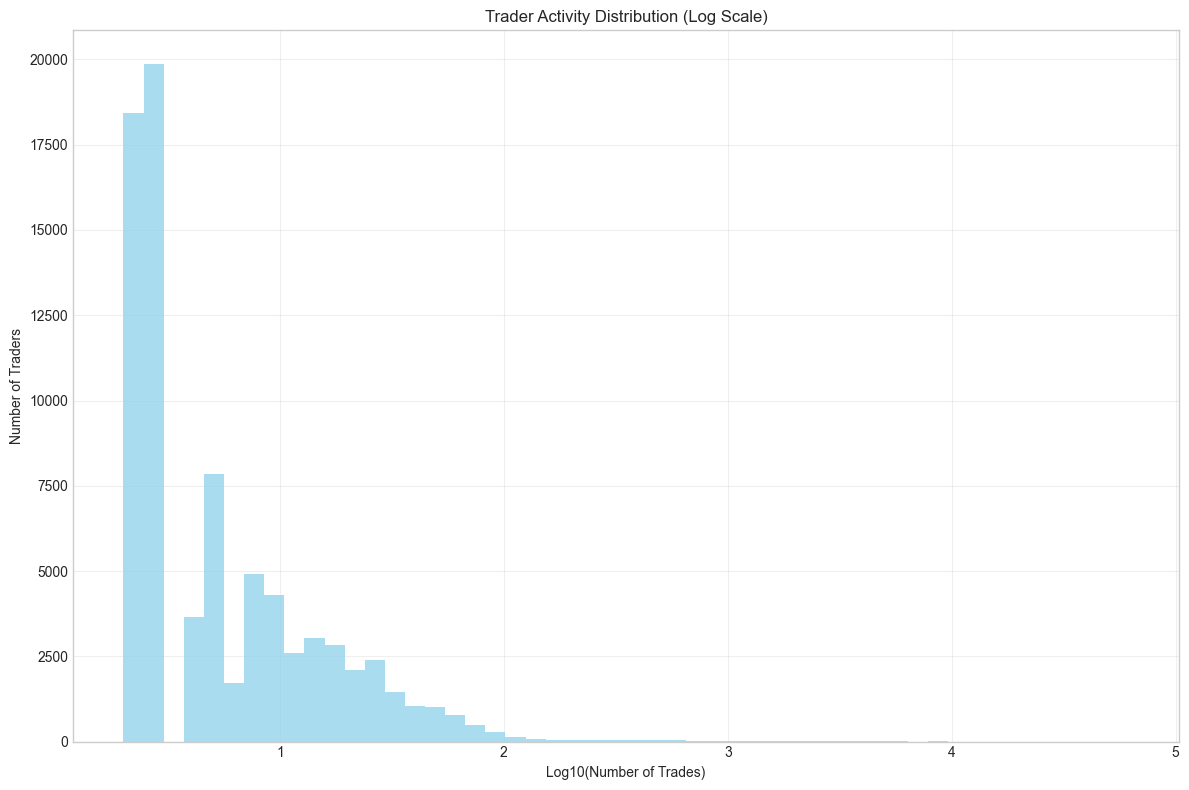

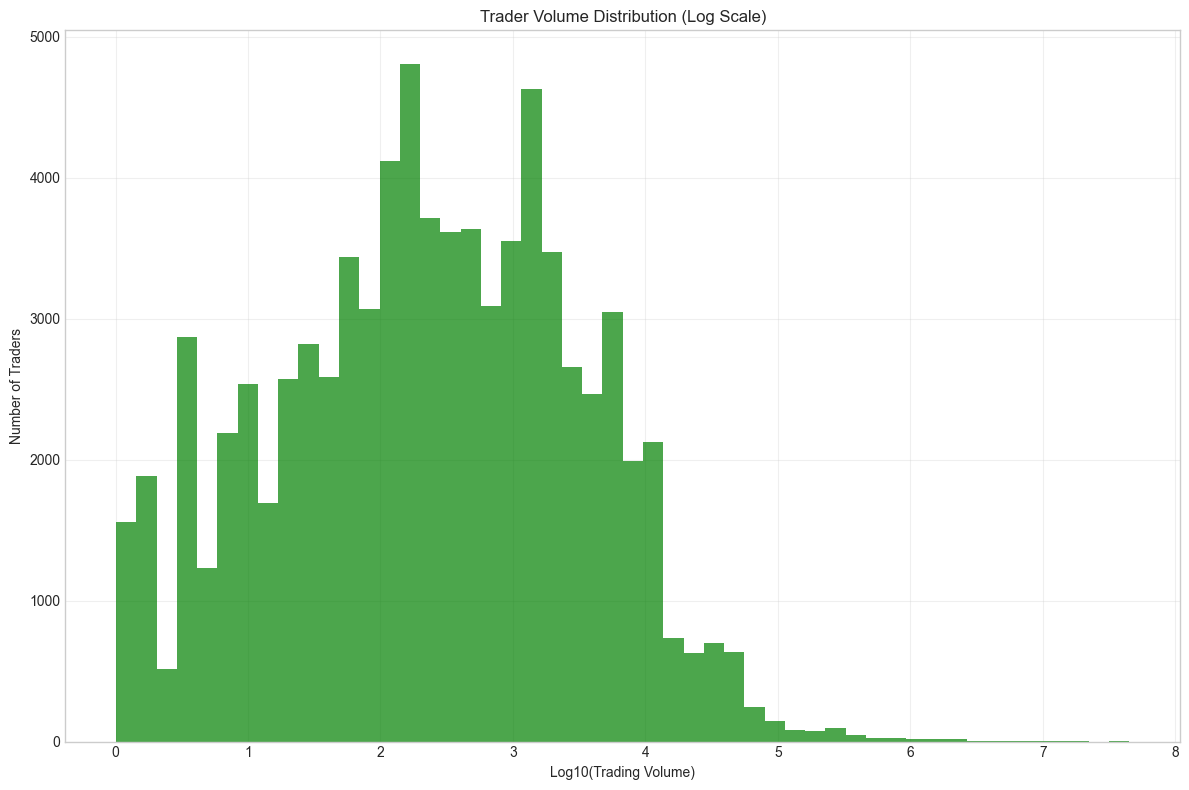


Running whale identification...

WHALE TRADER IDENTIFICATION
Total traders: 79,413
Total volume: 566,773,089.64
Volume concentration (Gini coefficient): 0.9368
Top 0.1% definition (79 traders): 46.84% of volume
Top 1.0% definition (794 traders): 68.27% of volume
Top 5.0% definition (3,970 traders): 83.59% of volume
Top 10.0% definition (7,941 traders): 89.92% of volume
Traders needed for 50% volume: 107 (0.1347% of all traders)
Traders needed for 75% volume: 1,630 (2.0526% of all traders)
Traders needed for 90% volume: 8,009 (10.0853% of all traders)
Traders needed for 95% volume: 14,360 (18.0827% of all traders)


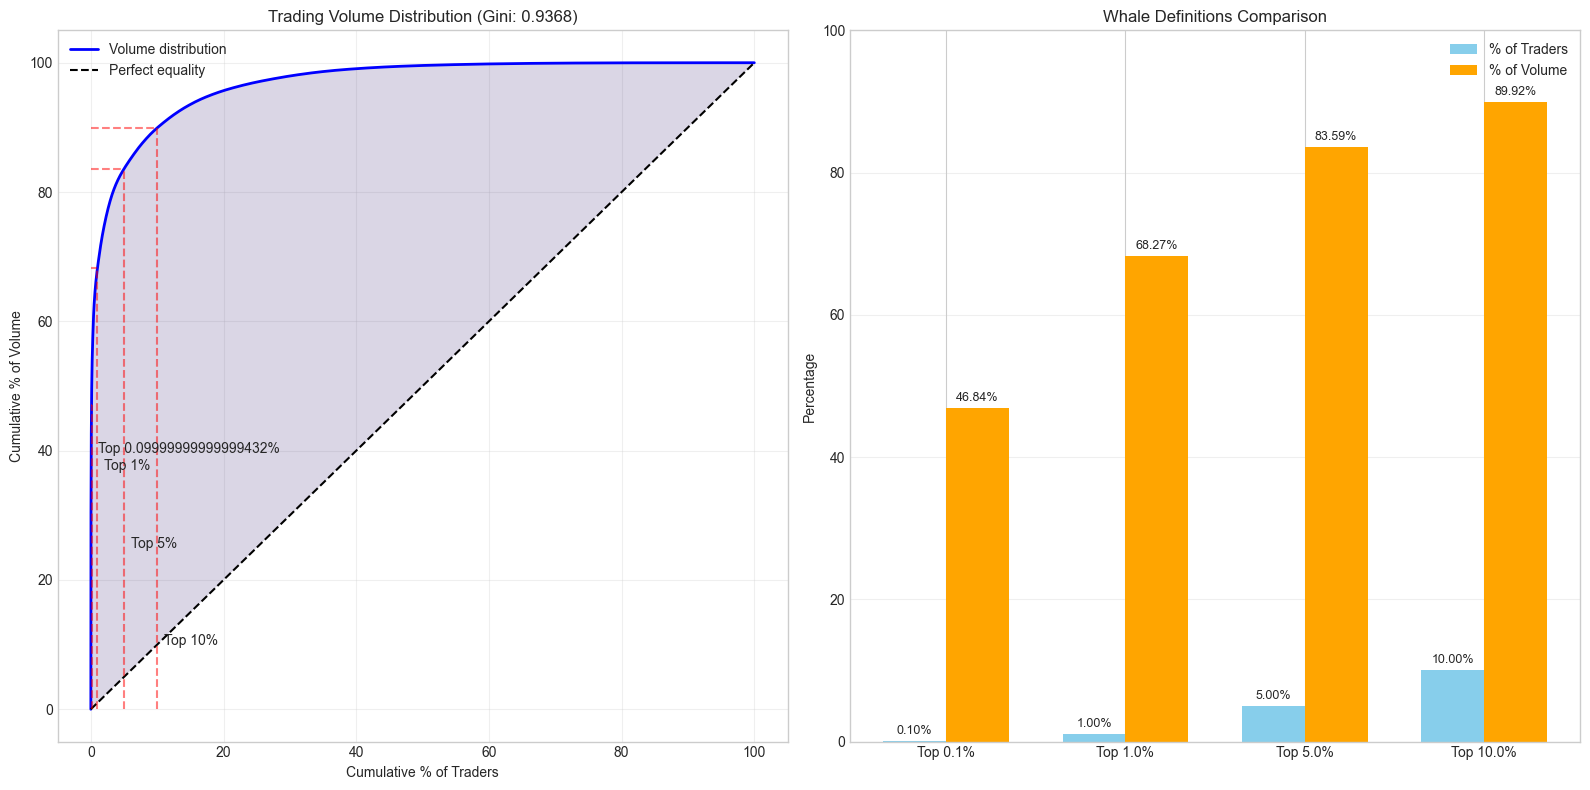

Whale definition analysis visualizations saved to whale_identification_analysis.png

Using top 1.0% definition: 794 whales
Selected whale threshold volume: 56681.02

Running trader classification...

Running market dynamics analysis...

MARKET DYNAMICS ANALYSIS
Analyzing 512301 whale trades and 672699 non-whale trades

Weighted average whale price impact: -0.002400
Weighted average non-whale price impact: 0.001828
Impact ratio (whale/non-whale): -1.3132


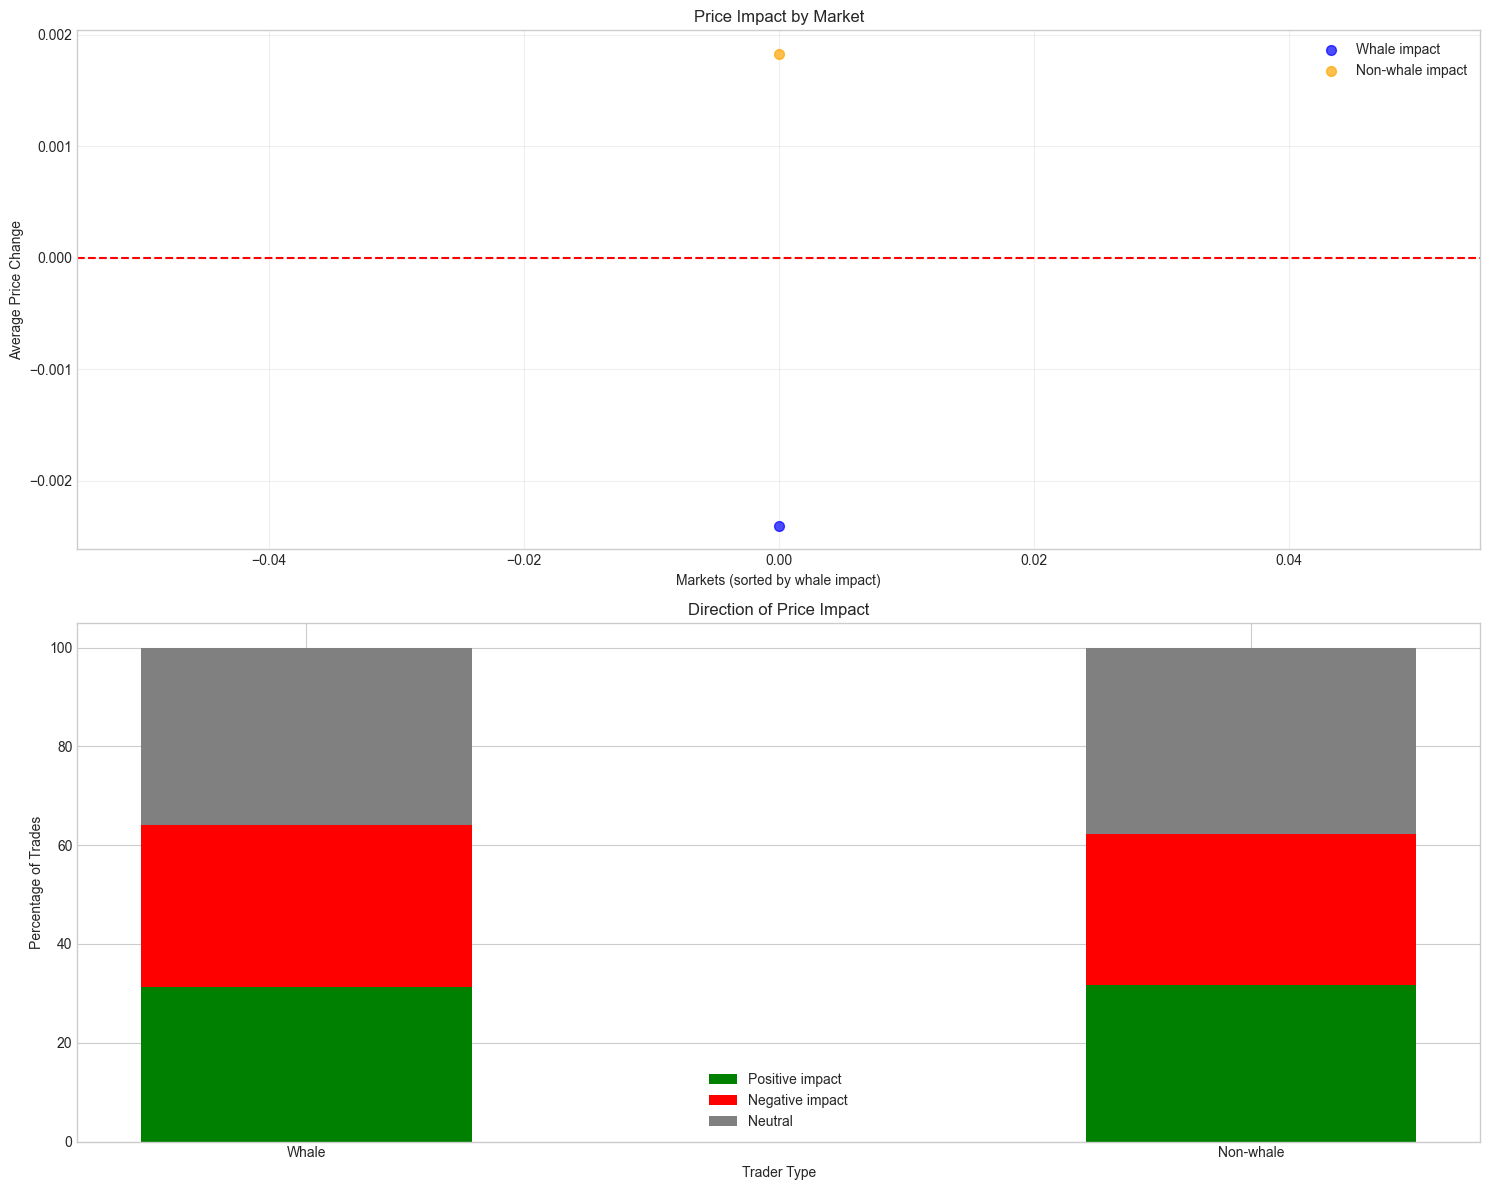

Market price impact visualization saved to market_dynamics_price_impact.png

Generating summary report...

GENERATING SUMMARY REPORT
Analysis summary saved to results/trader_analysis/analysis_summary.txt
Full JSON results saved to results/trader_analysis/analysis_summary.json

Analysis complete! Results saved to: results/trader_analysis


In [101]:
# Run all analyses and collect results
all_results = run_analysis()